# Prepare database

In this notebook I will write the general steps for creating and populating the relational database **putidafeatures.db**, that will compose the bulk of this work, starting from the data downloaded elsewhere

In [1]:
# import
import os
import re
import json
import sqlite3
import gffutils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# connects to the database
conn = sqlite3.connect("data/putidafeatures.db")

# creates a cursor
c = conn.cursor

With the database now connected, we can open the files present in the `data/` directory and start populating the **putidafeatures.db**.

For parsing data from the GFF file provided by NCBI I'm using [gffutils](https://daler.github.io/gffutils/)

In [11]:
# from the ncbi file
basedir = "data/ncbi"

# Specify the path to the .gff file containing all features relevant to putida
gff_match = ''.join(f for f in os.listdir(basedir) if f.endswith(".gff.gz"))

db = gffutils.create_db(f'{basedir}/{gff_match}', "ncbi_database.db", merge_strategy='create_unique')

# merge_strategy was needed because AMM02805.1 (and possibly more) is duplicated in the file!


Now that we have created an sqlite3 table out of the entire gff file, we can explore it to extract relevant information regarding the state of P. putida's annotated genome. First, let's discover how the database is organized

In [2]:
# Connect to the SQLite database
db = sqlite3.connect("ncbi_database.db")

# Create a cursor
cursor = db.cursor()

# Execute an SQL query to list all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch the table names
tables = cursor.fetchall()

# Display the table names
for table in tables:
    print(table[0])


features
relations
meta
directives
autoincrements
duplicates
sqlite_stat1


By the output above we can see that the database has 7 items (features, relations, meta, directives, autoincrements, duplicates, sqlite_stat1). We can investigate them further by figuring out how the first few records look like 

In [3]:
table_names = [item[0] for item in tables]

for table in table_names:
  print(f'contents for table: {table}')

  cursor.execute(f"SELECT * FROM {table} LIMIT 3;")

  rows = cursor.fetchall()

  for row in rows:
    print(row)

  print()
  

contents for table: features
('AE015451.2:1..6181873', 'AE015451.2', 'Genbank', 'region', 1, 6181873, '.', '+', '.', '{"ID":["AE015451.2:1..6181873"],"Dbxref":["taxon:160488"],"Is_circular":["true"],"Name":["ANONYMOUS"],"gbkey":["Src"],"genome":["chromosome"],"mol_type":["genomic DNA"],"strain":["KT2440"]}', '[]', 73)
('gene-PP_0001', 'AE015451.2', 'Genbank', 'gene', 147, 1019, '.', '-', '.', '{"ID":["gene-PP_0001"],"Name":["parB"],"gbkey":["Gene"],"gene":["parB"],"gene_biotype":["protein_coding"],"locus_tag":["PP_0001"]}', '[]', 4681)
('cds-AAN65635.1', 'AE015451.2', 'Genbank', 'CDS', 147, 1019, '.', '-', '0', '{"ID":["cds-AAN65635.1"],"Parent":["gene-PP_0001"],"Dbxref":["NCBI_GP:AAN65635.1"],"Name":["AAN65635.1"],"Note":["Evidence 2a : Function of homologous gene experimentally demonstrated in an other organism; PubMedId : 16306995, 17462018, 17729285; Product type pf : putative factor; Biologicalprocesses : Replicate"],"gbkey":["CDS"],"gene":["parB"],"locus_tag":["PP_0001"],"product

From the output above, we can see two immediately interesting tables: the table *relations*, which seems to provide an interesting lookup table for converting between locus tag and transcript name; and the table *features*, that contain the bulk of information provided in the GFF file. We are going to look deeper into the *features* table, looking for quantitative and qualitative information regarding genes throughout the genome.

## A deeper dive into the 'features' table

Due to the way GFF files work, we will want to retrieve the records containing

In [4]:
query = f"SELECT attributes FROM features WHERE id LIKE 'cds-%'"
#query = f"PRAGMA table_info(features)"

cursor.execute(query)

attr = cursor.fetchall()

attr_parsed = [json.loads(item[0]) for item in attr]

In [5]:
# obtaining information for the evidence level of each gene, according to the NCBI convention

ev_info = []

for item in attr_parsed:
   locus_tag =  item.get('locus_tag')
   note = item.get('Note')

   if locus_tag is not None:
    if note is None:
        ev_info.append((locus_tag[0], "Evidence zz : not reported;"))
    else:
        ev_info.append((locus_tag[0], note[0]))

ev_info[671]

('PP_0650', 'Evidence 7 : Gene remnant')

Now that we have isolated the evidence notes for every gene in P. putida's genome, we can try to understand the distribution of annotation quality for every gene in P. putida's genome. For this, we will use pandas dataframes and seaborn for visualizaiton.

In [6]:
ev_df = pd.DataFrame(ev_info, columns=["locus_tag", "evidence_type"])

# the evidence code will always be present due to our previous 
ev_df['evidence_code'] = ev_df['evidence_type'].str.extract(r'Evidence\s(.*?)\s:', expand=False)

ev_df['evidence_description'] = ev_df['evidence_type'].str.extract(r'(Evidence.*?(?=;)|Evidence.*?$)', expand=False)

# obtaining counts
summary = ev_df.groupby("evidence_code").size().reset_index(name="Count")
print(summary)

# printing the code meaning
print(ev_df['evidence_description'].unique())

## todo: this does not include genes with NA!!

   evidence_code  Count
0             1a     77
1             1b    103
2             1c    155
3             2a    849
4             2b    175
5              3    896
6              4   1494
7              5     79
8              6     24
9              7      1
10            zz   1712
['Evidence 2a : Function of homologous gene experimentally demonstrated in an other organism'
 'Evidence 2b : Function of strongly homologous gene'
 'Evidence 4 : Homologs of previously reported genes of unknown function'
 'Evidence 1b : Function experimentally demonstrated in the studied species'
 'Evidence 3 : Function proposed based on presence of conserved amino acid motif, structural feature or limited homology'
 'Evidence 5 : No homology to any previously reported sequences'
 'Evidence 1c : Function experimentally demonstrated in the studied genus'
 'Evidence zz : not reported'
 'Evidence 1a : Function experimentally demonstrated in the studied strain'
 'Evidence 6 : Doubtful CDS' 'Evidence 7 : Ge

/tmp/ipykernel_64917/3256081035.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='evidence_code', y='Count', hue='evidence_code', data=summary, ci=None)


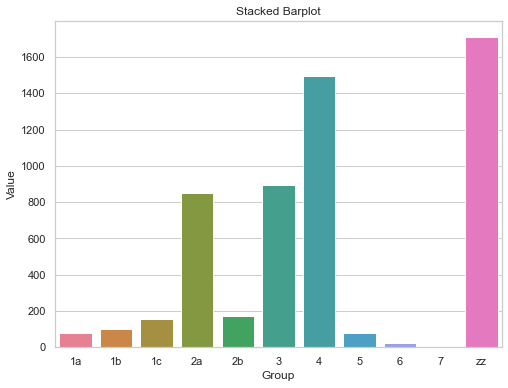

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(x='evidence_code', y='Count', hue='evidence_code', data=summary, ci=None)

plt.xlabel("Group")
plt.ylabel("Value")
plt.title("Stacked Barplot")

plt.show()


In [ ]:
# what are the genes without homology to any previously reported sequences?